### Thinking1
对于同一个带约束的规划问题，LP和MIP哪个运算复杂度高，为什么？

答：MIP的运算复杂度更高，因为MIP中，部分变量要求是整数，使得原本LP里可以利用数学推得到结果的方法（比如直接计算比较可行域的几个顶点位置的函数值）不再可行，而需要对可行域内的整数点进行暴力穷举，计算复杂度可能会达到指数级，尽管可以利用线性松弛问题等进行启发式搜索，但仍然有较高的计算复杂度。

### Thinking2
TSP与VRP问题的关系是怎样的？

答：如果说TSP问题是求如何安排访问顺序才能使一辆车以最短路径走完包含n个城市的环路，那VRP问题就是n个城市有各自的货物需求（货物量，最晚送达时间等），求如何安排车辆的配送任务和配送顺序才能以最少的车辆数和最短的总路程来完成送货任务。VRP比TSP更加复杂，也更加贴合实际应用场景。

### Aciton1
Santa的接待安排
圣诞节前100天，Santa开放了workshop，欢迎以家庭单位的参观，如何更合理的安排这些家庭参观？
每个家庭有10个选择choice0-9，数字代表了距离圣诞节的天数，比如 1代表12月24日，每个家庭必须并且只安排一次参观
家庭数量 5000，即family_id 为[0, 4999]，每天访问的人数需要在125-300人
为了更合理的计算Santa的安排能力，我们使用preference cost和accounting penalty两个指标
1）preference cost，代表Santa的个性化安排能力
2）accounting penalty，代表Santa安排的财务成本
每天接待的人员数N(d)如果大于125，就会拥挤，产生过多的清洁成本
最终的 Score = preference cost + accounting penalty
最终提交每个家庭的安排 submission.csv

#### Step1 数据加载

In [52]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
# 数据加载
import pandas as pd

data = pd.read_csv('./family_data.csv', index_col='family_id')
data

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4
...,...,...,...,...,...,...,...,...,...,...,...
4995,16,1,66,33,18,70,56,46,86,60,4
4996,88,66,20,17,26,54,81,91,59,48,2
4997,32,66,54,17,27,21,74,81,3,7,6


#### Step2 数据预处理
* 1）计算每个家庭人数 **family_size**
* 2）记录每个家庭的倾向选择(choice_1 ~ choice_10) **desired**
* 3）计算preference cost矩阵 **pcost**
* 4）计算accounting penalty矩阵 **acost**

##### family_size

In [2]:
family_size = data.iloc[:,-1].values
family_size

array([4, 4, 3, ..., 6, 5, 4], dtype=int64)

##### desired

In [3]:
desired = data.values[:,:-1]-1 # 为了之后索引方便1~100 -> 0~99
desired

array([[51, 37, 11, ..., 75,  9, 27],
       [25,  3, 81, ...,  5, 65, 60],
       [99, 53, 24, ..., 88, 79, 32],
       ...,
       [31, 65, 53, ..., 80,  2,  6],
       [66, 91,  3, ..., 11, 25, 69],
       [12, 10, 24, ..., 38, 17, 46]], dtype=int64)

##### pcost

In [4]:
def get_pcost(n, choice): # n代表家庭成员的个数
    cost = None
    if choice == 0:
        cost = 0
    if choice == 1:
        cost = 50
    if choice == 2:
        cost = 50 + n*9
    if choice == 3:
        cost = 100 + n*9
    if choice == 4:
        cost = 200 + n*9
    if choice == 5:
        cost = 200 + n*18
    if choice == 6:
        cost = 300 + n*18
    if choice == 7:
        cost = 300 + n*36
    if choice == 8:
        cost = 400 + n*36
    if choice == 9:
        cost = 500 + n*(36+199)
    if choice > 9:
        cost = 500 + n*(36+398)
    return cost

In [104]:
%%time
n_days = 100 # 安排的天数
n_families = 5000 # 家庭个数
min_occupancy = 125 # 最小承载量
max_occupancy = 300 # 最大承载量

# 计算不同家庭不同日期到访的pcost
import numpy as np

pcost = np.zeros((5000,100))
for f in range(n_families):
    f_num = family_size[f]
    # 初始化，默认都是choice_10(otherwize)
    pcost[f,:] = get_pcost(f_num, 11)
    for choice in range(10):
#         day = data.loc[f][choice]     # 用data.loc要5s
#         pcost[f,day-1] = get_pcost(f_num, choice)
        day = desired[f][choice]
        pcost[f,day] = get_pcost(f_num, choice)
pcost

Wall time: 76.8 ms


array([[2236., 2236., 2236., ..., 2236., 2236., 2236.],
       [2236., 2236., 2236., ..., 2236., 2236., 2236.],
       [1802., 1802., 1802., ..., 1802., 1802.,    0.],
       ...,
       [3104., 3104.,  616., ..., 3104., 3104., 3104.],
       [ 390., 2670., 2670., ..., 2670., 2670., 2670.],
       [2236., 2236., 2236., ..., 2236., 2236., 2236.]])

##### acost

In [6]:
%%time
# 每天0~300个人
acost = np.zeros(shape=(max_occupancy+1, max_occupancy+1), dtype=np.float64) # float64计算更精确
for i in range(acost.shape[0]): # 当天安排的人数
    for j in range(acost.shape[1]): # 前一天安排的人数
        diff = abs(i-j)
        acost[i][j] = max(0, (i-125)/400 * i**(1/2 + diff/50))
acost

Wall time: 77.8 ms


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.16316072e+15, 3.71482922e+15, 3.31477861e+15, ...,
        7.46610759e+00, 8.36716954e+00, 9.37697794e+00],
       [4.79555148e+15, 4.27883100e+15, 3.81778713e+15, ...,
        8.43020770e+00, 7.52185316e+00, 8.43020770e+00],
       [5.52415954e+15, 4.92860244e+15, 4.39725208e+15, ...,
        9.51970597e+00, 8.49339085e+00, 7.57772228e+00]])

#### Step3 求解LP/MIP
* 1）使用LP对大部分家庭进行规划
* 2）使用MIP对剩余家庭进行规划
* 3）汇总结果

In [114]:
from ortools.linear_solver import pywraplp
# 线性规划
def solveLP(families, Type='LP', Min=min_occupancy, Max=max_occupancy, n=25): # n为人为约束的前后两天人数浮动范围
    if Type == 'LP':
        solver= pywraplp.Solver('AssignmentProblem', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    if Type == 'MIP':
        solver = pywraplp.Solver('AssignmentProblem', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    x = {} # family_id在j天是否参观
    # 每一天有哪些家庭
    candidates = [[] for x in range(n_days)]
    for i in families:
        for j in desired[i,:]:
#         for j in range(n_days):
            candidates[j].append(i)
            # 定义变量
            x[i,j] = solver.BoolVar('x[%i, %i]' % (i,j))
#             print(x)
    
    # 每天参观人数
    daily_occupancy = [solver.Sum([x[i, j] * family_size[i] for i in candidates[j]]) for j in range(n_days)]
    
    # 每个家庭在desired中的参观总次数
    family_presence = [solver.Sum([x[i,j] for j in desired[i,:]]) for i in families]
    
    # 定义目标函数
    preference_cost = solver.Sum([x[i,j] * pcost[i,j] for i in families for j in desired[i,:]])
    
    # 目标是最小化目标函数
    solver.Minimize(preference_cost)
    
    #约束条件
    # 人为增加约束条件
    for j in range(n_days-1):
        # 当前人数比前一天浮动在n以内
        solver.Add(daily_occupancy[j] - daily_occupancy[j+1] <= n)
        solver.Add(daily_occupancy[j+1] - daily_occupancy[j] <= n)
        
    # 每个家庭有且只有一次参观
    for i in range(len(family_presence)):
        solver.Add(family_presence[i] == 1)
    
    # 每天参观人数125~300
    if type(Min) is int:
        Min = list([Min]*n_days)
    if type(Max) is int:
        Max = list([Max]*n_days)
    for j in range(n_days):
        solver.Add(daily_occupancy[j] >= Min[j])
        solver.Add(daily_occupancy[j] <= Max[j])
    
    # 求解
    result = solver.Solve()
    
    # 得到参观日期安排
    temp = [(i, j, x[i,j].solution_value()) for i in families\
            for j in desired[i,:] if x[i,j].solution_value() > 0]
    print(solver.Objective().Value())
    df = pd.DataFrame(temp, columns=['family_id','day','result'])
    return df

In [162]:
def solve_santa(n_1, n_2=float('inf'), thre=0.99):
    # LP安排大部分
    all_families = list(range(n_families))
    result = solveLP(all_families, Type='LP', n=n_1)
    assigned_df = result[result.result > thre]
    assigned_df['family_size'] = family_size[assigned_df.family_id]
    occupancy = assigned_df.groupby('day').family_size.sum().values
    
    # MIP安排余下未安排好的
    min_rest = np.maximum(0, min_occupancy-occupancy)
    max_rest = max_occupancy - occupancy
    rest_family = [i for i in range(n_families) if i not in assigned_df.family_id.values]
    rest = solveLP(rest_family, Type='MIP', Min=min_rest, Max=max_rest, n=n_2)
    final_result = pd.concat((assigned_df[['family_id', 'day']], rest[['family_id', 'day']]))
    return final_result

In [367]:
%%time
final = solve_santa(25,thre=0.99)
cost_function(final)

73702.31696428571
1401.0
Wall time: 10.9 s


77596.69049325124

#### Step4 结果评估与呈现

In [413]:
# 根据安排计算cost
def Pcost(prediction):
    cost = 0
    daily_occupancy = np.zeros(n_days, dtype=np.int64)
    for i,d in prediction.values:
        cost += pcost[i][d]
        n = family_size[i]
        daily_occupancy[d] += n
    return cost, daily_occupancy

def Acost(daily_occupancy):
    cost = 0
    try:
        for j in range(n_days-1):
            cost += acost[daily_occupancy[j], daily_occupancy[j+1]]
#         cost += acost[daily_occupancy[99], 0] # 假设第101天不营业，即参观人数为0,导致cost太大
    except IndexError:
#         print("Error: 超过承载范围")
        pass
    else:
        return cost
    
def cost_function(prediction):
    p, daily_occupancy = Pcost(prediction)
    a = Acost(daily_occupancy)
    cost = p + a
    return cost

In [274]:
import matplotlib.pyplot as plt
def plot_daily(prediction):
    result = prediction.copy()
    result['family_size'] = family_size[result.family_id]
    daily_occupancy = result.groupby('day').family_size.sum()
    plt.bar(daily_occupancy.index,daily_occupancy.values, width=0.5, color='orange')
    plt.xlabel('day')
    plt.ylabel('counts')
    plt.show()

In [414]:
sum_cost = cost_function(final)
sum_cost

77596.69049325124

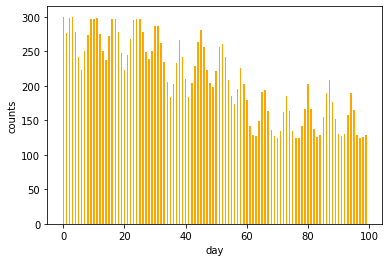

In [275]:
plot_daily(final)

#### Step5 优化方案

In [385]:
def find_better(prediction):
    sorted_families = np.argsort(-family_size) # 按人数对家庭进行排序
    score = cost_function(prediction)
    original_score = np.inf
    pred = prediction.set_index('family_id')['day']
    
    while score < original_score:
        original_score = score
        
        for i in sorted_families:
            for option in range(10):
                try:
                    day = desired[i, option]
                    oldday = pred[i]
                    pred[i] = day
                    prediction = pred.reset_index()
                    newscore = cost_function(prediction)
                except Exception as e:
                    newscore = float('inf')
                if newscore < score:
                    score = newscore
                else:
                    pred[i] = oldday
                print(score, end='\r')
    print(score)
    return prediction

In [ ]:
%%time
better = find_better(final)

70397.27488449651

In [271]:
def save_result(prediction, filename):
    pred = prediction.copy()
    pred['day'] = pred['day'] + 1
    pred.rename(columns = {'day': 'assigned_day'}, inplace=True)
    pred.to_csv(filename, index=False)
    print(filename + ' saved')
save_result(final, 'subnission.csv')

subnission.csv saved
